# Bases de Datos II. NoSQL MongoDB 3 (sesión 4)

```
                                                                  ,gggggggggggg,    ,ggggggggggg,  
                                                                 dP"""88""""""Y8b, dP"""88""""""Y8,
                                                                 Yb,  88       `8b,Yb,  88      `8b
                                                                  `"  88        `8b `"  88      ,8P
                                                                      88         Y8     88aaaad8P"
  ,ggg,,ggg,,ggg,     ,ggggg,    ,ggg,,ggg,     ,gggg,gg    ,ggggg,   88         d8     88""""Y8ba
 ,8" "8P" "8P" "8,   dP"  "Y8ggg,8" "8P" "8,   dP"  "Y8I   dP"  "Y8ggg88        ,8P     88      `8b
 I8   8I   8I   8I  i8'    ,8I  I8   8I   8I  i8'    ,8I  i8'    ,8I  88       ,8P'     88      ,8P
,dP   8I   8I   Yb,,d8,   ,d8' ,dP   8I   Yb,,d8,   ,d8I ,d8,   ,d8'  88______,dP'      88_____,d8'
8P'   8I   8I   `Y8P"Y8888P"   8P'   8I   `Y8P"Y8888P"888P"Y8888P"   888888888P"       88888888P"  
                                                    ,d8I'                                          
                                                  ,dP'8I                                           
                                                 ,8"  8I                                           
                                                 I8   8I                                           
                                                 `8, ,8I                                           
                                                  `Y8P"                             
                                                  
                                                                 
                                             ______
|_  _  _  _  _     _| _     _| _ _|_ _  _     |  |
|_)(_|_> (/__>    (_|(/_   (_|(_| |_(_)_>    _|__|_
```


![MongoDB](https://webassets.mongodb.com/_com_assets/cms/MongoDB_Logo_FullColorBlack_RGB-4td3yuxzjs.png)

Esta hoja es la tercera entrega y última del trabajo con MongoDB. Veremos temas avanzados como cálculos `aggregate()` más complejos, el uso de índices, etc. Al final habrá un conjunto de ejercicios que habrá que resolver y entregar en la tarea abierta para la ocasión.

## Inicio de la hoja


In [1]:
RunningInCOLAB: bool = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [2]:
!sudo apt-get update -qq
!sudo apt-get install -y -qq gpg p7zip

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Instalación inicial de MongoDB (sólo necesaria en Google Colab)

In [3]:
if RunningInCOLAB:
  !wget -q https://raw.githubusercontent.com/dsevilla/bdge/refs/heads/24-25/addendum/mongo-utils/run-mongo-local.sh
  !bash run-mongo-local.sh

Adding system user `mongodb' (UID 104) ...
Adding new user `mongodb' (UID 104) with group `nogroup' ...
Not creating home directory `/home/mongodb'.
Adding group `mongodb' (GID 107) ...
Done.
Adding user `mongodb' to group `mongodb' ...
Adding user mongodb to group mongodb
Done.
deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/8.0 multiverse
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-

## Descarga de los datos en formato CSV

 - Formato: 7zipped
 - Ficheros:
   - **Comments**.csv
       - Id
       - PostId
       - Score
       - Text, e.g.: "@Stu Thompson: Seems possible to me - why not try it?"
       - CreationDate, e.g.:"2008-09-06T08:07:10.730"
       - UserId
   - **Posts**.csv
       - Id
       - PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName="Jeff Atwood"
       - LastEditDate="2009-03-05T22:28:34.823"
       - LastActivityDate="2009-03-11T12:51:01.480"
       - CommunityOwnedDate="2009-03-11T12:51:01.480"
       - ClosedDate="2009-03-11T12:51:01.480"
       - Title=
       - Tags=
       - AnswerCount
       - CommentCount
       - FavoriteCount
   - **Tags**.csv
    - Id
    - Count
    - ExcerptPostId
    - TagName
    - WikiPostId
   - **Users**.csv
     - Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes
   - **Votes**.csv
     - Id
     - PostId
     - VoteTypeId
        - ` 1`: AcceptedByOriginator
        - ` 2`: UpMod
        - ` 3`: DownMod
        - ` 4`: Offensive
        - ` 5`: Favorite - if VoteTypeId = 5 UserId will be populated
        - ` 6`: Close
        - ` 7`: Reopen
        - ` 8`: BountyStart
        - ` 9`: BountyClose
        - `10`: Deletion
        - `11`: Undeletion
        - `12`: Spam
        - `13`: InformModerator
     - CreationDate
     - UserId (only for VoteTypeId 5)
     - BountyAmount (only for VoteTypeId 9)

In [4]:
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001 -O - > es.stackoverflow.csv.7z
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002 -O - >> es.stackoverflow.csv.7z

--2025-03-06 15:45:54--  https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001 [following]
--2025-03-06 15:45:54--  https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 100.00M   319MB/s    in 0.3s    

2025-03-06 15:45:57 (319 MB/s) - writ

In [5]:
!7zr x es.stackoverflow.csv.7z
!rm es.stackoverflow.csv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 200457538 bytes (192 MiB)

Extracting archive: es.stackoverflow.csv.7z
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% - Comments.csv                     1% - Comments.csv                     2% - Comments.csv                     3% - Comments.csv                     4% - Comments.csv                     5% - Comments.csv                     6% - Comments.csv           

In [6]:
!head Users.csv

Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
-1,"<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href=""http://meta.stackoverflow.com/a/92006"">Quitar preguntas abandonadas</a></li><br/></ul><br/>",-1,2015-10-26T21:36:24.767,Comunidad,22504,2015-10-26T21:36:24.767,en la granja de servidores,1,10211,2516,
1,"<p>Dev #2 who helped create Stack Overflow currently

## Instalación de la librería `pymongo`

In [7]:
%pip install --upgrade pymongo tqdm pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [8]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [9]:
from pymongo import MongoClient

## Conexión a la base de datos

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (`mongo`), o bien a `localhost` si lo estamos haciendo en Colab.

In [10]:
import os
db_hostname: str = "localhost" if RunningInCOLAB else os.getenv('DB_HOSTNAME', "mongo")

In [11]:
from typing import Any

client: MongoClient[dict[str, Any]] = MongoClient(db_hostname,27017)
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [12]:
client.list_database_names()

['admin', 'config', 'local']

Las bases de datos se crean conforme se nombran. Se puede utilizar la notación punto o la de diccionario. Las colecciones también.

In [13]:
from pymongo.database import Database

db: Database[dict[str,Any]] = client.stackoverflow
# db: Database = client['stackoverflow'] # (equivalente)
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow')

## Importación de los ficheros CSV

Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [14]:
import csv
import sys
from datetime import datetime
from pymongo.collection import Collection
from typing import Any
from collections.abc import Callable, Iterable, Iterator
from tqdm.notebook import tqdm

def batched(iterable: Iterable, n) -> Iterable:
    from itertools import islice
    if n < 1:
        raise ValueError('n must be at least one')
    it: Iterator = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

def csv_to_mongo(file: str, coll: Collection):
    """
    Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
    dentro de la base de datos, y date_cols las columnas que serán interpretadas
    como fechas.
    """
    # Convertir todos los elementos que se puedan a números
    def to_numeric(d: str) -> str| int | float:
        if len(d) == 0:
            return ''
        if not ((d[0] >= '0' and d[0] <= '9') or d[0] == '-' or d[0] == '+' or d[0]=='.'):
            return d
        try:
            return int(d) if abs(int(d)) <= sys.maxsize else d # Ensure number is inside MongoDB max number range
        except ValueError:
            try:
                return float(d)
            except ValueError:
                return d

    def to_date(d: str) -> datetime | None:
        """To ISO Date. If this cannot be converted, return NULL (None)"""
        try:
            return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f")
        except ValueError:
            return None

    coll.drop()

    with open(file, encoding='utf-8') as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns: list[str] = next(reader)

        # Las columnas que contienen 'Date' se interpretan como fechas
        func_to_cols: list[Callable[[str], Any]] = list(map(lambda c: to_date if 'date' in c.lower() else to_numeric, columns))

        for batch in batched(tqdm(reader, desc='Leyendo e insertando filas...'), 10000):
            docs: list[dict[str, str | datetime | float | int | None]] = []
            for row in batch:
                built_row: list[str | datetime | float | int | None] = [func(e) for (func,e) in zip(func_to_cols, row)]
                docs.append(dict(zip(columns, built_row)))
            coll.insert_many(docs)

        print("¡Hecho!")

In [15]:
csv_to_mongo('Posts.csv',db.posts)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [16]:
csv_to_mongo('Users.csv',db.users)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [17]:
csv_to_mongo('Votes.csv',db.votes)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [18]:
csv_to_mongo('Comments.csv',db.comments)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [19]:
csv_to_mongo('Tags.csv',db.tags)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [20]:
posts: Collection[dict[str,Any]] = db.posts
posts

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'posts')

In [21]:
posts.count_documents({})

410346

### El API de colección de MongoDB

El API de colección en Python se puede encontrar aquí: https://docs.mongodb.com/drivers/pymongo/. La mayoría de libros y referencias muestran el uso de mongo desde Javascript, ya que el *shell* de MongoDB acepta ese lenguaje. La sintaxis con respecto a Python cambia un poco, y se puede seguir en el enlace anterior. Existe incluso un curso de la MongoDB University que se puede realizar de forma gratuita: https://learn.mongodb.com/learning-paths/using-mongodb-with-python

## Framework de Agregación

Framework de agregación:
- Aquí está la referencia de las diferentes etapas por las que puede pasar un pipeline: https://www.mongodb.com/docs/manual/reference/operator/aggregation-pipeline/.
- Y aquí los distintos operadores que se permiten dentro de las etapas: https://docs.mongodb.com/manual/reference/operator/aggregation/.
- Y aquí incluso un libro completo con usos prácticos de ejecutar agregación: https://www.practical-mongodb-aggregations.com/.

A continuación otro vídeo interseante:

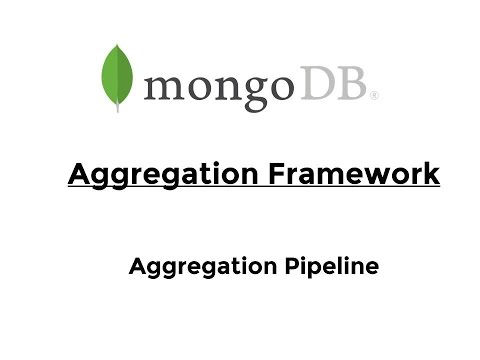

In [22]:
from IPython.display import YouTubeVideo
YouTubeVideo('VSX4a3h4SmQ',width=600)

![](https://miro.medium.com/max/1060/1*2lDBxvZ8Cr3JYkoODTa0lQ.png)

Proyección: el operador `$project` permite filtar qué campos de los documentos queremos usar en la siguientes fases de agregación.

In [23]:
from pymongo.command_cursor import CommandCursor

respuestas: CommandCursor[dict[str,Any]] = db['posts'].aggregate( [
    {'$project' : { 'Id' : True }},
    {'$limit': 20} ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb0688'), 'Id': 1},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0689'), 'Id': 2},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068a'), 'Id': 3},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068b'), 'Id': 4},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068c'), 'Id': 5},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068d'), 'Id': 6},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068e'), 'Id': 7},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb068f'), 'Id': 8},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0690'), 'Id': 9},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0691'), 'Id': 10},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0692'), 'Id': 11},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0693'), 'Id': 12},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0694'), 'Id': 14},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0695'), 'Id': 15},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0696'), 'Id': 16},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0697'), 'Id': 17},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0698'), 'Id': 18},
 {'_id': ObjectId('67c9

_Lookup_! El operador `$lookup` permite realizar búsquedas en otras colecciones. Podrían interpretarse como un `join` en el modelo relacional.

In [24]:
respuestas: CommandCursor[dict[str,Any]] = posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 150}}},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        }
        ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb06ac'),
  'Id': 40,
  'AcceptedAnswerId': '',
  'AnswerCount': '',
  'Body': '<p>Asumiendo que se está haciendo un <code>join</code> de columnas sin duplicados, lo cuál es un caso común:</p><br/><ul><br/><li><p>Un <strong>inner join</strong> de A y B entregará el resultado de la intersección de los conjuntos A y B. En otras palabras, la parte <em>interna</em> –intersección– en un diagrama de Venn.</p><br/></li><br/><li><p>Un <strong>full outer join</strong> entre A y B entregará el resultado de la unión de A y B. En otras palabras, la parte <em>externa</em> –unión– en un diagrama de Venn .</p><br/></li><br/></ul><br/><h1>Ejemplos:</h1><br/><p>Supongamos que tenemos dos tablas, con una sola columna cada una y los siguientes datos:</p><br/><pre><code>A    B<br/>-    -<br/>1    3<br/>2    4<br/>3    5<br/>4    6<br/></code></pre><br/><p>Nota que (1,2) solo se encuentran en A, (3,4) son comunes y (5,6) solamente se encuentran en B.</p><br/><h1>Inner J

El `$lookup` genera un _array_ con todos los resultados. El operador `$arrayElementAt` accede al primer elemento.

In [25]:
respuestas: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 150}}},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        },
        { '$project' : {
            'Id' : True,
            'Score' : True,
            'username' : {'$arrayElemAt' : ['$owner.DisplayName', 0]},
            'owner.DisplayName' : True
          }}
        ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb06ac'),
  'Id': 40,
  'Score': 206,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb072c'),
  'Id': 197,
  'Score': 176,
  'owner': [{'DisplayName': 'Peter Olson'}],
  'username': 'Peter Olson'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0730'),
  'Id': 204,
  'Score': 195,
  'owner': [{'DisplayName': 'Konamiman'}],
  'username': 'Konamiman'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efa'),
  'Id': 18232,
  'Score': 232,
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efb'),
  'Id': 18233,
  'Score': 219,
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c37b9b86ef3b0adc07b1'),
  'Id': 87842,
  'Score': 173,
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'}]

`$unwind` también puede usarse. "Desdobla" cada fila por cada elemento del array. En este caso, como sabemos que el array sólo contiene un elemento, sólo habrá una fila por fila original, pero sin el _array_. Finalmente se puede proyectar el campo que se quiera. Volvemos a proyectar los campos anteriores para comprobar las diferencias.

In [26]:
respuestas: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 150}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
            'Id' : True,
            'Score' : True,
            'username': '$owner.DisplayName',
            'owner.DisplayName' : True
          }
        }
        ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb06ac'),
  'Id': 40,
  'Score': 206,
  'owner': {'DisplayName': 'jachguate'},
  'username': 'jachguate'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb072c'),
  'Id': 197,
  'Score': 176,
  'owner': {'DisplayName': 'Peter Olson'},
  'username': 'Peter Olson'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0730'),
  'Id': 204,
  'Score': 195,
  'owner': {'DisplayName': 'Konamiman'},
  'username': 'Konamiman'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efa'),
  'Id': 18232,
  'Score': 232,
  'owner': {'DisplayName': 'Alvaro Montoro'},
  'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efb'),
  'Id': 18233,
  'Score': 219,
  'owner': {'DisplayName': 'Alvaro Montoro'},
  'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c37b9b86ef3b0adc07b1'),
  'Id': 87842,
  'Score': 173,
  'owner': {'DisplayName': 'Alvaro Montoro'},
  'username': 'Alvaro Montoro'}]

Repetimos la consulta anterior, pero proyectando solamente el campo 'username'.

In [27]:
respuestas: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 150}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
            'username': '$owner.DisplayName',
          }
        }
        ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb06ac'), 'username': 'jachguate'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb072c'), 'username': 'Peter Olson'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0730'), 'username': 'Konamiman'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efa'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efb'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c37b9b86ef3b0adc07b1'), 'username': 'Alvaro Montoro'}]

Veamos cómo se ha realizado la consulta anterior. Para ello usamos la opción `explain`. En el campo `strategy` que se ha usado `NestedLoopJoin`. Para cada documento en `posts`, busca ''manualmente'' en `users` los documentos que coincidan con `OwnerUserId`.

In [28]:
db.command('aggregate', 'posts', pipeline= [
  { '$match': { 'Score' : {'$gte': 150}}},
  { '$lookup': {
      'from': "users",
      'localField': "OwnerUserId",
      'foreignField': "Id",
      'as': "owner"
    }
  },
  { '$unwind': '$owner'},
  { '$project': {
      'username': '$owner.DisplayName',

     }
  }
  ],
  explain = True
)

{'explainVersion': '1',
 'stages': [{'$cursor': {'queryPlanner': {'namespace': 'stackoverflow.posts',
     'parsedQuery': {'Score': {'$gte': 150}},
     'indexFilterSet': False,
     'queryHash': 'FE018D7F',
     'planCacheShapeHash': 'FE018D7F',
     'planCacheKey': '632B2F53',
     'optimizationTimeMillis': 0,
     'maxIndexedOrSolutionsReached': False,
     'maxIndexedAndSolutionsReached': False,
     'maxScansToExplodeReached': False,
     'prunedSimilarIndexes': False,
     'winningPlan': {'isCached': False,
      'stage': 'PROJECTION_SIMPLE',
      'transformBy': {'OwnerUserId': 1, '_id': 1},
      'inputStage': {'stage': 'COLLSCAN',
       'filter': {'Score': {'$gte': 150}},
       'direction': 'forward'}},
     'rejectedPlans': []}}},
  {'$lookup': {'from': 'users',
    'as': 'owner',
    'localField': 'OwnerUserId',
    'foreignField': 'Id',
    'unwinding': {'preserveNullAndEmptyArrays': False}}},
  {'$project': {'_id': True, 'username': '$owner.DisplayName'}}],
 'queryShapeH

## Definición de índices

Las consultas anteriores no se han podido realizar, ya que el uso de `$lookup` (equivalente a un JOIN de SQL) hace que se tenga que buscar en toda la colección usuarios para encontrar el usuario con `Id` especificado por `OwnerUserId`. Vamos a probarlas sin limitación después de crear un índice.


In [29]:
from pymongo import HASHED

db.users.create_index(['Id', HASHED])

'Id_1_hashed_1'

In [30]:
respuestas: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
  { '$match': { 'Score' : {'$gte': 150}}},
  { '$lookup': {
      'from': "users",
      'localField': "OwnerUserId",
      'foreignField': "Id",
      'as': "owner"
    }
  },
  { '$unwind': '$owner'},
  { '$project' : {
        'username': '$owner.DisplayName'
    }
  }
  ])
list(respuestas)

[{'_id': ObjectId('67c9c36f9b86ef3b0adb06ac'), 'username': 'jachguate'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb072c'), 'username': 'Peter Olson'},
 {'_id': ObjectId('67c9c36f9b86ef3b0adb0730'), 'username': 'Konamiman'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efa'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c3739b86ef3b0adb3efb'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('67c9c37b9b86ef3b0adc07b1'), 'username': 'Alvaro Montoro'}]

Veamos cómo se ha usado el índice en la consulta (no se incluye la consulta entera porque el explain no lo termina de hacer bien si hay muchos pasos). De nuevo usamos la opción `explain`. En el campo `strategy` que se ha usado `IndexedLoopJoin`. En este caso se utiliza el índice creado en `users` para hacer la búsqueda de una forma más rápida y eficiente.

In [31]:
db.command('aggregate', 'posts', pipeline= [
  { '$match': { 'Score' : {'$gte': 150}}},
  { '$lookup': {
      'from': "users",
      'localField': "OwnerUserId",
      'foreignField': "Id",
      'as': "owner"
    }
  }],
  explain = True
)

{'explainVersion': '2',
 'queryPlanner': {'namespace': 'stackoverflow.posts',
  'parsedQuery': {'Score': {'$gte': 150}},
  'indexFilterSet': False,
  'queryHash': '0873BBE5',
  'planCacheShapeHash': '0873BBE5',
  'planCacheKey': 'D1416C01',
  'optimizationTimeMillis': 0,
  'optimizedPipeline': True,
  'maxIndexedOrSolutionsReached': False,
  'maxIndexedAndSolutionsReached': False,
  'maxScansToExplodeReached': False,
  'prunedSimilarIndexes': False,
  'winningPlan': {'isCached': False,
   'queryPlan': {'stage': 'EQ_LOOKUP',
    'planNodeId': 2,
    'foreignCollection': 'stackoverflow.users',
    'localField': 'OwnerUserId',
    'foreignField': 'Id',
    'asField': 'owner',
    'strategy': 'IndexedLoopJoin',
    'indexName': 'Id_1_hashed_1',
    'indexKeyPattern': {'Id': 1, 'hashed': 1},
    'scanDirection': 'forward',
    'inputStage': {'stage': 'COLLSCAN',
     'planNodeId': 1,
     'filter': {'Score': {'$gte': 150}},
     'direction': 'forward'}},
   'slotBasedPlan': {'slots': '$$RES

Calculemos la media de puntuación por usuario:

In [32]:
media_puntuación_usuarios: CommandCursor[dict[str,Any]] = db.posts.aggregate([
    {
        '$group': {
            '_id': '$OwnerUserId',
            'media_puntuación': { '$avg':  '$Score' }
            }
    },
    { '$limit': 100 }
    ])
list(media_puntuación_usuarios)

[{'_id': 115574, 'media_puntuación': 2.0},
 {'_id': 279684, 'media_puntuación': 0.0},
 {'_id': 215808, 'media_puntuación': 1.0},
 {'_id': 159641, 'media_puntuación': 0.0},
 {'_id': 227132, 'media_puntuación': 1.0},
 {'_id': 236176, 'media_puntuación': 1.0},
 {'_id': 212317, 'media_puntuación': 1.0},
 {'_id': 27152, 'media_puntuación': 0.0},
 {'_id': 144269, 'media_puntuación': 2.0},
 {'_id': 44994, 'media_puntuación': 0.25},
 {'_id': 44742, 'media_puntuación': -1.0},
 {'_id': 138187, 'media_puntuación': 0.4},
 {'_id': 310071, 'media_puntuación': 1.0},
 {'_id': 192863, 'media_puntuación': 0.0},
 {'_id': 231288, 'media_puntuación': 0.0},
 {'_id': 85211, 'media_puntuación': 0.0},
 {'_id': 176812, 'media_puntuación': 1.0},
 {'_id': 114308, 'media_puntuación': 0.47058823529411764},
 {'_id': 19610, 'media_puntuación': 2.6536912751677852},
 {'_id': 31856, 'media_puntuación': 0.4},
 {'_id': 51453, 'media_puntuación': -1.0},
 {'_id': 12715, 'media_puntuación': 0.6},
 {'_id': 165826, 'media_punt

Calculemos el máximo y mínimo de puntuación de cada usuario:

In [33]:
max_min_puntuación_usuarios: CommandCursor[dict[str,Any]] = db.posts.aggregate([
    {
        '$group': {
            '_id': '$OwnerUserId',
            'media_puntuación': { '$avg':  '$Score' },
            'min': { '$min':  '$Score' },
            'max': { '$max' : "$Score"}
        }
    },
    { '$limit': 100 }
    ])
list(max_min_puntuación_usuarios)

[{'_id': 25459, 'media_puntuación': 0.9826086956521739, 'min': -7, 'max': 7},
 {'_id': 215894, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 72701, 'media_puntuación': 2.0, 'min': 2, 'max': 2},
 {'_id': 243898, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 255323, 'media_puntuación': 0.8571428571428571, 'min': 0, 'max': 5},
 {'_id': 20358, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 148161, 'media_puntuación': 3.0, 'min': 3, 'max': 3},
 {'_id': 45989, 'media_puntuación': 0.6923076923076923, 'min': 0, 'max': 6},
 {'_id': 117749, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 102754, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 3131, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 172102, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 5324, 'media_puntuación': 0.7142857142857143, 'min': 0, 'max': 3},
 {'_id': 213577, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 95018, 'media_puntuación': -0.3333333333333333, 'min': -

Pasemos ahora a trabajar con la colección Votes. Antes de empezar, veamos las primeras líneas del fichero `Votes.csv`:

In [34]:
!head Votes.csv

Id,BountyAmount,CreationDate,PostId,UserId,VoteTypeId
1,,2015-10-29T00:00:00.000,1,,2
2,,2015-10-29T00:00:00.000,2,,2
3,,2015-10-30T00:00:00.000,3,,2
4,,2015-10-30T00:00:00.000,5,,2
5,,2015-10-30T00:00:00.000,7,,2
7,,2015-10-30T00:00:00.000,3,,16
8,,2015-10-30T00:00:00.000,4,,2
9,,2015-10-30T00:00:00.000,1,,2
10,,2015-10-30T00:00:00.000,1,,16


Podemos comprobar que todos los posts tienen los votos correctos contando los votos positivos (`VoteTypeId=2`) y negativos (`VoteTypeId=3`).

Primero, calcular el resultado de cada voto. Nótese cómo haciendo uso de `$cond` se puede aplicar una condición `if` para sumar o restar dependiendo del tipo del voto.

Después lo comprobaremos con los existentes en Posts.

In [35]:
score_by_post: CommandCursor[dict[str,Any]] = db.votes.aggregate([
    { "$match" : {"$or" : [ {"VoteTypeId" : 2},
                            {"VoteTypeId" : 3}]
                  }
    },
    {
        '$group': {
            '_id': '$PostId',
            'score': { '$sum': { "$cond": {
                                            "if" : { "$eq" : [ "$VoteTypeId", 2 ]},
                                            "then" : 1,
                                            "else" : -1
                                          }} }
        }
    },
    { '$limit' : 20}
    ])
list(score_by_post)

[{'_id': 93663, 'score': 2},
 {'_id': 208100, 'score': 2},
 {'_id': 133784, 'score': -1},
 {'_id': 90680, 'score': 2},
 {'_id': 38589, 'score': 2},
 {'_id': 173957, 'score': -1},
 {'_id': 264630, 'score': -1},
 {'_id': 354556, 'score': -1},
 {'_id': 456847, 'score': -2},
 {'_id': 172162, 'score': 2},
 {'_id': 406409, 'score': 2},
 {'_id': 463500, 'score': -3},
 {'_id': 526857, 'score': 1},
 {'_id': 87611, 'score': 1},
 {'_id': 336900, 'score': 1},
 {'_id': 375597, 'score': 2},
 {'_id': 294451, 'score': 2},
 {'_id': 268351, 'score': 1},
 {'_id': 455944, 'score': 1},
 {'_id': 330434, 'score': 1}]

Y después comparado con lo que hay en los Posts. La consulta, como se puede ver, sacará sólo los elementos en donde los votos en `Votes` no coincide con `Posts` (debe ser vacío). Nótese el uso de la nueva construcción `$expr`, que permite añadir expresiones dentro de la consulta.

**CUIDADO** Si no se define el índice correcto, la consulta tarda mucho. ¿Cuál?

In [36]:
# Creación del índice secreto... ¿cuál?
import zlib
secret_code = b'x\x9cKI\xd2+\xc8/.)\xd6K.JM,I\x8d\xcf\xccKI\xad\xd0\x88V\xf7LQ\xd7Q\xf0p\x0c\xf6pu\x89\xd5\x04\x00\xfe`\x0cD'
eval(zlib.decompress(secret_code).decode())

'Id_1_hashed_1'

In [37]:
score_by_post_comp: CommandCursor[dict[str,Any]] = db.votes.aggregate([
    { "$match" : {"$or" : [ {"VoteTypeId" : 2},
                            {"VoteTypeId" : 3}]
                  }
    },
    {
        '$group': {
            '_id': '$PostId',
            'score': { '$sum': { "$cond" : {
                                            "if" : { "$eq" : [ "$VoteTypeId", 2 ]},
                                            "then" : 1,
                                            "else" : -1
                                           }}}
        }
    },
    {
        "$lookup": {
            'from': "posts",
            'localField': "_id",
            'foreignField': "Id",
            'as': "post"
        }
    },
    { "$unwind" : "$post"},
    {
        "$match" : {'$expr' : {'$ne' : [ '$score', '$post.Score']}}
    }
])
list(score_by_post_comp)

[]

### Ejemplo de realización de una consulta de reciprocidad

Como ejemplo de consulta compleja con el Framework de Agregación, adjunto una posible solución a la consulta siguiente: ¿Hay usuarios que hacen preguntas y son respondidos por otros usuarios que a su vez preguntaron y fueron respondidos por los primeros? (Es decir, ¿hay reciprocidad en las interacciones en Stacokverflow español?)

In [38]:
RQ4: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
        { "$match" : {"PostTypeId": 2}},
        { '$lookup': {
            'from': "posts",
            'localField': "ParentId",
            'foreignField': "Id",
            'as': "question"
          }
        },

        { '$unwind' : '$question' },

        { '$project' : {
            'OwnerUserId': True,
            'OP' : '$question.OwnerUserId'
          }
        },
        { '$group' : {'_id' : {'min' : { '$min' : ['$OwnerUserId' , '$OP'] },
                               'max' : { '$max' : ['$OwnerUserId' , '$OP'] }},
                      'pairs' : {'$addToSet' : { '0q': '$OP', '1a': '$OwnerUserId'}}
          }
        },
        { '$project': {
            'pairs' : True,
            'npairs' : { '$size' : '$pairs'}
          }
        },
        { '$match' : { 'npairs' : { '$eq' : 2}} }
    ])
RQ4 = list(RQ4)
RQ4

[{'_id': {'min': 6564, 'max': ''},
  'pairs': [{'0q': 6564, '1a': ''}, {'0q': '', '1a': 6564}],
  'npairs': 2},
 {'_id': {'min': 56195, 'max': ''},
  'pairs': [{'0q': 56195, '1a': ''}, {'0q': '', '1a': 56195}],
  'npairs': 2},
 {'_id': {'min': 70975, 'max': ''},
  'pairs': [{'0q': 70975, '1a': ''}, {'0q': '', '1a': 70975}],
  'npairs': 2},
 {'_id': {'min': 22429, 'max': ''},
  'pairs': [{'0q': 22429, '1a': ''}, {'0q': '', '1a': 22429}],
  'npairs': 2},
 {'_id': {'min': 250, 'max': 19610},
  'pairs': [{'0q': 19610, '1a': 250}, {'0q': 250, '1a': 19610}],
  'npairs': 2},
 {'_id': {'min': 95341, 'max': 96682},
  'pairs': [{'0q': 96682, '1a': 95341}, {'0q': 95341, '1a': 96682}],
  'npairs': 2},
 {'_id': {'min': 158389, 'max': 158505},
  'pairs': [{'0q': 158389, '1a': 158505}, {'0q': 158505, '1a': 158389}],
  'npairs': 2},
 {'_id': {'min': 9754, 'max': ''},
  'pairs': [{'0q': 9754, '1a': ''}, {'0q': '', '1a': 9754}],
  'npairs': 2},
 {'_id': {'min': 10775, 'max': 38468},
  'pairs': [{'0q': 3

En el caso de que queramos tener como referencia las preguntas y respuestas a las que se refiere la conversación, se puede añadir un campo más que guarde todas las preguntas junto con sus respuestas consideradas:

In [39]:
RQ4: CommandCursor[dict[str,Any]] = db.posts.aggregate( [
        { '$match': { 'PostTypeId' : 2}},
        { '$lookup': {
            'from': "posts",
            'localField': "ParentId",
            'foreignField': "Id",
            'as': "question"
          }
        },

        { '$unwind' : '$question' },

        { '$project' : {
            'OwnerUserId': True,
            'QId' : '$question.Id',
            'AId' : '$Id',
            'OP' : '$question.OwnerUserId'
          }
        },
        { '$group' : {'_id' : {'min' : { '$min' : ['$OwnerUserId' , '$OP'] },
                               'max' : { '$max' : ['$OwnerUserId' , '$OP'] }},
                      'pairs' : {'$addToSet' : { '0q':'$OP', '1a': '$OwnerUserId'}},
                      'considered_pairs' : { '$push' : {'QId' : '$QId', 'AId' : '$AId'}}
          }
        },
        { '$project': {
            'pairs' : True,
            'npairs' : { '$size' : '$pairs'},
            'considered_pairs' : True
          }
        },
        { '$match' : { 'npairs' : { '$eq' : 2}} }
    ])
RQ4 = list(RQ4)
RQ4

[{'_id': {'min': 21, 'max': 1184},
  'pairs': [{'0q': 21, '1a': 1184}, {'0q': 1184, '1a': 21}],
  'considered_pairs': [{'QId': 2615, 'AId': 2619},
   {'QId': 36, 'AId': 47441},
   {'QId': 4630, 'AId': 446773}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 288},
  'pairs': [{'0q': 288, '1a': 22}, {'0q': 22, '1a': 288}],
  'considered_pairs': [{'QId': 565, 'AId': 604}, {'QId': 731, 'AId': 734}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 342},
  'pairs': [{'0q': 342, '1a': 22}, {'0q': 22, '1a': 342}],
  'considered_pairs': [{'QId': 618, 'AId': 623}, {'QId': 552, 'AId': 832}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 729},
  'pairs': [{'0q': 729, '1a': 22}, {'0q': 22, '1a': 729}],
  'considered_pairs': [{'QId': 2454, 'AId': 2459}, {'QId': 1919, 'AId': 2734}],
  'npairs': 2},
 {'_id': {'min': 23, 'max': 25},
  'pairs': [{'0q': 23, '1a': 25}, {'0q': 25, '1a': 23}],
  'considered_pairs': [{'QId': 48, 'AId': 52},
   {'QId': 803, 'AId': 805},
   {'QId': 1015, 'AId': 1095}],
  'npairs': 2},


Comprobemos ahora cuatro entradas que están relacionadas dos a dos.

In [40]:
(db.posts.find_one({'Id': 238}), db.posts.find_one({'Id': 243}),
db.posts.find_one({'Id': 222}), db.posts.find_one({'Id': 223}))

({'_id': ObjectId('67c9c36f9b86ef3b0adb0750'),
  'Id': 238,
  'AcceptedAnswerId': 243,
  'AnswerCount': 1,
  'Body': "<p>Estoy observando un mensaje de alerta (no es un error) <code>InsecurePlatformWarning</code> al ejecutar el comando <code>pip</code> en Linux:</p><br/><br/><pre><code>$ pip search reportlab<br/>/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:90:<br/>         InsecurePlatformWarning: A true SSLContext object is not available.<br/>         This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail.<br/>         For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.<br/>  InsecurePlatformWarning<br/>reportlab           - The ReportLab Toolkit<br/></code></pre><br/><br/><p>Tengo instalada la última versión de <code>pip</code>:</p><br/><br/><pre><code>$ pip show pip<br/>---<br/>Metadata-Version: 2.0<br/>Name: pip<br/>Version: 7.1.2<br/>S

### Ejemplo de consulta: Tiempo medio desde que se hace una pregunta hasta que se le da la primera respuesta

Veamos cómo calcular el tiempo medio desde que se hace una pregunta hasta que se le da la primera respuesta. No se considerarán pues las preguntas que no tienen respuesta, lo cual es razonable.

Esto sólo calcula el tiempo mínimo de cada pregunta a su respuesta. Después se añadirá el código que calcula la media final:

In [41]:
min_answer_time: CommandCursor[dict[str,Any]] = db.posts.aggregate([
    { "$match" : {"PostTypeId" : 2} },
    { '$group' : {
        '_id' : '$ParentId',
        # 'answers' : { '$push' : {'Id' : "$Id", 'CreationDate' : "$CreationDate"}},
        'min' : {'$min' : "$CreationDate"}
      }
    },
    { "$lookup" : {
        'from': "posts",
        'localField': "_id",
        'foreignField': "Id",
        'as': "post"}
    },
    { "$unwind" : "$post"},
    { "$project" : {
        "_id" : True,
        "min" : True,
        "diff" : {"$subtract" : ["$min", "$post.CreationDate"]}
      }
    }
])
min_answer_time = list(min_answer_time)
min_answer_time

[{'_id': 202880,
  'min': datetime.datetime(2018, 10, 8, 18, 22, 19, 317000),
  'diff': 3217577},
 {'_id': 83691,
  'min': datetime.datetime(2017, 7, 4, 17, 1, 39, 867000),
  'diff': 2566564},
 {'_id': 577025,
  'min': datetime.datetime(2023, 1, 10, 13, 10, 33, 403000),
  'diff': 418124023},
 {'_id': 56413,
  'min': datetime.datetime(2017, 3, 22, 17, 50, 38, 963000),
  'diff': 262370283},
 {'_id': 275767,
  'min': datetime.datetime(2019, 6, 30, 23, 3, 54, 963000),
  'diff': 3401173},
 {'_id': 342703,
  'min': datetime.datetime(2020, 4, 2, 3, 49, 9, 287000),
  'diff': 9476917},
 {'_id': 170529,
  'min': datetime.datetime(2018, 6, 4, 21, 35, 12, 347000),
  'diff': 259077},
 {'_id': 174033,
  'min': datetime.datetime(2018, 6, 18, 23, 2, 27, 160000),
  'diff': 454467},
 {'_id': 175914,
  'min': datetime.datetime(2018, 6, 26, 15, 58, 9, 823000),
  'diff': 4807880},
 {'_id': 321719,
  'min': datetime.datetime(2020, 1, 19, 20, 1, 2, 690000),
  'diff': 448591990},
 {'_id': 405406,
  'min': dat

La siguiente consulta sí calcula la media:

In [42]:
avg_answer_time: CommandCursor[dict[str,Any]] = db.posts.aggregate([
    { "$match" : {"PostTypeId" : 2} },
    { '$group' : {
        '_id' : '$ParentId',
        # 'answers' : { '$push' : {'Id' : "$Id", 'CreationDate' : "$CreationDate"}},
        'min' : {'$min' : "$CreationDate"}
      }
    },
    { "$lookup" : {
        'from': "posts",
        'localField': "_id",
        'foreignField': "Id",
        'as': "post"}
    },
    { "$unwind" : "$post"},
    { "$project" : {
        "_id" : True,
        "min" : True,
        "diff" : {"$subtract" : ["$min", "$post.CreationDate"]}
      }
    },
    #    { "$sort" : {'_id' : 1} }
    {
      "$group" :  {
        "_id" : None,
        "avg" : { "$avg" : "$diff"}
      }
    }
])
avg_answer_time = list(avg_answer_time)
avg_answer_time

[{'_id': None, 'avg': 943326388.0748069}]

## EJERCICIO 1: Listar aquellos usuarios con una reputación (`Reputation`) superior o igual a 500 y un número de visualizaciones (`Views`) superior a 200. De dichos usuarios solo mostrar los campos:
- `DisplayName`
- `Location`
- `Reputation`
- `Views`

*IMPORTANTE: No mostrar el campo `_id`*

In [50]:
respuesta: CommandCursor[dict[str,Any]] = db.users.aggregate([
      { "$match" : { "Reputation" : { "$gte" : 500},
                     "Views" : { "$gt" : 200}
                  }
      },
      { "$project" : {
          "DisplayName" : True,
          "Location" : True,
          "Reputation" : True,
          "Views" : True,
          "_id" : False
        }
      }
    ])
respuesta = list(respuesta)
respuesta

[{'DisplayName': 'Carlos Muñoz',
  'Location': 'Lima, Peru',
  'Reputation': 13368,
  'Views': 2231},
 {'DisplayName': 'jachguate',
  'Location': 'Guatemala',
  'Reputation': 30128,
  'Views': 2892},
 {'DisplayName': 'Konamiman',
  'Location': 'Palma de Mallorca, Spain',
  'Reputation': 5278,
  'Views': 787},
 {'DisplayName': 'Angel Angel',
  'Location': '',
  'Reputation': 10093,
  'Views': 1023},
 {'DisplayName': 'rnrneverdies',
  'Location': 'Argentina',
  'Reputation': 16867,
  'Views': 1643},
 {'DisplayName': 'Lamak',
  'Location': 'Chile',
  'Reputation': 8505,
  'Views': 1348},
 {'DisplayName': 'Diego', 'Location': '', 'Reputation': 5693, 'Views': 332},
 {'DisplayName': 'Davlio',
  'Location': 'Lima, Peru',
  'Reputation': 2980,
  'Views': 333},
 {'DisplayName': 'Rubén',
  'Location': 'Monterrey, Mexico',
  'Reputation': 11406,
  'Views': 1886},
 {'DisplayName': 'Shaz',
  'Location': 'Canada / Colombia',
  'Reputation': 29168,
  'Views': 4246},
 {'DisplayName': 'astrojuanlu',
  

## EJERCICIO 2: Listar todos post que son preguntas y sus votos asociados. Para ello, se permite definir los indices que se consideren adecuados.

*Ejemplo*: Suponiendo que el post con `_id` `65e6f1c8d93b356db73e5433` tuviera tres votos asociados, la solución debe devolver una salida de en este formato (nótese que los campos `CreationDate`, `Score` e `_id` se refieren al mismo post):

```json
{'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 2}},
 {'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 2}},
 {'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 16}}
```


In [55]:
from pymongo import HASHED
db.users.create_index(['PostId', HASHED])

preguntas_votos: CommandCursor[dict[str,Any]] = db.posts.aggregate([
    { "$match" : {"PostTypeId": 1}},
    { "$lookup" : {
        'from': "votes",
        'localField': "_id",
        'foreignField': "PostId",
        'as': "post_votes"
        }
    },
    { "$unwind" : "$post_votes"},
    { "$project" : {
        "CreationDate" : True,
        "Score" : True,
        "_id" : True,
        "post_votes" : True
        }
    },
    { "$limit": 10}
])
preguntas_votos = list(preguntas_votos)
preguntas_votos

KeyboardInterrupt: 

## EJERCICIO 3: Listar los nombres de usuarios (campo `DisplayName` de `users`) que tienen más preguntas que respuestas

(Contando los usuarios debe salir exactamente 54483 usuarios).

## EJERCICIO 4: Comprobad, de forma similar a los ejemplos anteriores, que el campo `CommentCount` de `Posts` es correcto, comprobándolo con la colección `Comments`. Definid los índices necesarios.

El resultado de la consulta de los números de comentarios que difieren debe ser vacío como en el ejemplo de los votos anterior.
